In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
import mpld3
mpld3.enable_notebook()
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
tar_scaler=preprocessing.MinMaxScaler()
df=pd.read_csv('v2_2.csv', sep=',',header=0)
labels=df['close']
df=df.drop(['Date','TickerName','open','high','low','volume'],axis=1)
labels_py=labels.to_numpy(dtype='int64')
labels_py=labels_py.reshape(-1,1)
labels_py_scaled=tar_scaler.fit_transform(labels_py)
#change
data=df['close'].to_numpy(dtype='int64')
data=data.reshape(-1,1)
data_scaled=min_max_scaler.fit_transform(data)
print(len(data_scaled))
print(data_scaled.shape[-1])


157208
1


In [3]:
#GENERATOR
def generator(data, lookback, delay, min_index, max_index,row_gen,
              shuffle=False, batch_size=128, step=6):
#shift the min and max indexes to incorporate the delay and lookback.
    print("inside gen")
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            #this condition starts drawing batches from the start again and the remaining data points are left as it is.
            if i + batch_size >= max_index:
                i = min_index + lookback
            #max index is involved here because while drawing the last batch, it should consider only the batch size.
            rows = np.arange(i, min(i + batch_size, max_index))
            #here i remembers the end index of the previous batch, so that next time the batch begins from here.
            i += len(rows)
    #rows here are just indices referring to the slice and the samples in the bigger picture.
    #lookback//step gives the timesteps for each samples or rows mentioned above.
    #data.shape[-1] gives us the columnar data: total 24.
        samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
        targets = np.zeros((len(rows),))
        r=np.zeros((len(rows),data.shape[-1]))

        for j, row in enumerate(rows):
            #print("inside loop")
        #indices here refers the indices or samples that serves as input to the particular jth sample.
        #in the next line, you can clearly see for the jth sample, you go back the lookback window, and take out
        #the sample that comes after step.
        #In a nutshell, all the 30 days ka data is not included from lookback window, the data is included after a period of step.
        #It makes sense because for N AND N+1th sample most of the lookback data will be same, but with steps we dont have that problem.
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            #if(data[rows[j]+delay][23]-data[rows[j]][23]>=0):
            #    targets[j]=1
            #else:
            #    targets[j]=0
            #the below comment is for prediction
            targets[j] = data[rows[j] + delay][0]
            r[j]=data[rows[j]]

        #print(samples)
        if(row_gen==True):
            yield samples,r, targets
        else:
            yield samples, targets

In [4]:
#Following the previous explanation, this makes total sense. FOr each sample, we will have 5 input rows and 1 output row.
#the shape of a sample will be (5,24)
lookback = 30
step = 6
delay = 7
batch_size = 128


train_gen = generator(data_scaled,lookback=lookback,delay=delay,min_index=0,max_index=100000,row_gen=False,shuffle=True,step=step,batch_size=batch_size)

val_gen = generator(data_scaled,
lookback=lookback,
delay=delay,
min_index=100001,
max_index=125000,
row_gen=False,                    
step=step,
batch_size=batch_size)

test_gen = generator(data_scaled,
lookback=lookback,
delay=delay,
min_index=125001,
max_index=None,
row_gen=False,                     
step=step,
batch_size=batch_size)

val_steps = 194
#(125000 - 100001 - lookback)
test_steps =250
#(len(data_scaled) - 125001 - lookback)

In [5]:
i=0
while True:
    try:
        samples,targets=next(train_gen)
        print(samples.shape)
        print(targets)
        i=i+1
        break
    except StopIteration:
        break
    
#total is 100000, so you would draw 100000/128 batches=781.25. In effect, you should draw 780.
#They should be 24999/128=195.3==194
#32208/128=251.6=250



inside gen
(128, 5, 1)
[0.02599098 0.15013055 0.00391645 0.00261097 0.0096131  0.01436031
 0.03026347 0.00427249 0.00225493 0.01851412 0.03845241 0.00676478
 0.10503204 0.00522193 0.07464989 0.26252077 0.01174935 0.02599098
 0.01495371 0.01436031 0.12247804 0.06206978 0.06895324 0.00047472
 0.09411346 0.07322573 0.00439117 0.00652742 0.00071208 0.02183717
 0.00094944 0.00284833 0.01720864 0.0258723  0.00700214 0.00629005
 0.0354854  0.20187515 0.0011868  0.09102777 0.0360788  0.00071208
 0.16638975 0.20769048 0.01091859 0.01376691 0.07370045 0.10882981
 0.01115595 0.03999525 0.01079991 0.02492286 0.0770235  0.01661524
 0.00593401 0.00439117 0.22869689 0.01519108 0.00106812 0.0011868
 0.03774033 0.02254925 0.0011868  0.00142416 0.14585806 0.03168763
 0.01661524 0.00154284 0.01008782 0.00913838 0.01614052 0.04557323
 0.034892   0.18585331 0.00379777 0.00249229 0.02895799 0.00925706
 0.00439117 0.01388559 0.04569191 0.1883456  0.14075481 0.00213624
 0.00771422 0.0770235  0.01827676 0.0111

In [6]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
#model.add(layers.Embedding(24, 10))
model.add(layers.LSTM(10, return_sequences = True, input_shape = (lookback//step, data_scaled.shape[-1])))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 10)             480       
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________


In [7]:
def infinite_sequence():
    num = 0
    while True:
        yield num
        num += 1
        
gen=infinite_sequence()
print(next(gen))
print(next(gen))

print(next(train_gen))

0
1
(array([[[1.62591977e-02],
        [1.59031569e-02],
        [1.54284358e-02],
        [1.55471161e-02],
        [1.62591977e-02]],

       [[8.92475671e-02],
        [9.41134583e-02],
        [9.25706148e-02],
        [9.13838120e-02],
        [8.67552813e-02]],

       [[2.30239734e-02],
        [2.21932115e-02],
        [2.40920959e-02],
        [2.39734156e-02],
        [2.44481367e-02]],

       [[1.51554712e-01],
        [1.57132685e-01],
        [1.45264657e-01],
        [1.43603133e-01],
        [1.37313079e-01]],

       [[6.55115120e-02],
        [6.00522193e-02],
        [6.08829812e-02],
        [6.37313079e-02],
        [6.50367909e-02]],

       [[3.60788037e-02],
        [3.75029670e-02],
        [3.90458106e-02],
        [3.99952528e-02],
        [3.94018514e-02]],

       [[2.97887491e-02],
        [3.12129124e-02],
        [2.75338239e-02],
        [3.29931165e-02],
        [3.32304771e-02]],

       [[1.42772371e-01],
        [1.39924045e-01],
        [1.36007596

In [8]:
#steps per epoch might refer to the no of times the generator is called. // It is true.

history = model.fit(train_gen,
steps_per_epoch=780,
epochs=10,
validation_data=val_gen,
validation_steps=val_steps)

Epoch 1/10
780/780 [==============================] - 5s 4ms/step - loss: 0.0329 - val_loss: 0.0082
Epoch 2/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0099 - val_loss: 0.0053
Epoch 3/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 4/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0088 - val_loss: 0.0045
Epoch 5/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0082 - val_loss: 0.0030
Epoch 6/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 7/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 8/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0074 - val_loss: 0.0027
Epoch 9/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 10/10
780/780 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0027

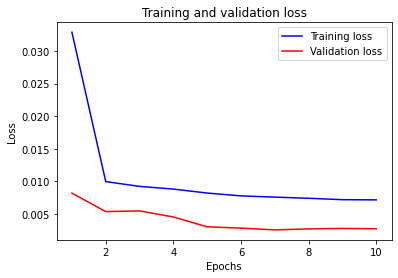

In [9]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 11)

plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_scores = model.evaluate(test_gen,steps=test_steps, verbose=1)


inside gen
250/250 [==============================] - 0s 2ms/step - loss: 0.0102


In [11]:
preds=model.predict(test_gen,steps=250,verbose=1)

250/250 [==============================] - 1s 2ms/step


In [12]:
test_gen_excel = generator(data_scaled,
lookback=lookback,
delay=delay,
min_index=125001,
max_index=None,
row_gen=True,                           
step=step,
batch_size=batch_size)

In [13]:
print(preds)

#preds_unscaled=min_max_scaler.inverse_transform(preds)
steps=test_steps
whole_samples,whole_rows,whole_targets=next(test_gen_excel)
print(whole_rows.shape)
for i in range(steps-1):
    samples,row,targets=next(test_gen_excel)
    whole_samples=np.concatenate((whole_samples,samples),axis=0)
    whole_targets=np.concatenate((whole_targets,targets),axis=0)
    whole_rows=np.concatenate((whole_rows,row),axis=0)
    

#whole=np.concatenate((whole,preds),axis=1)
#print(whole)
#preds=preds.flatten()    
print(whole_samples)
whole_targets=np.reshape(whole_targets,(whole_targets.shape[0],1))
print(whole_targets)
print(whole_rows)
#print(preds_unscaled)

[[0.00356602]
 [0.00345214]
 [0.00347471]
 ...
 [0.0507847 ]
 [0.05108068]
 [0.05088158]]
inside gen
(128, 1)
[[[0.00545929]
  [0.00522193]
  [0.00391645]
  [0.00486589]
  [0.00510325]]

 [[0.00522193]
  [0.00498457]
  [0.00367909]
  [0.00510325]
  [0.00486589]]

 [[0.00534061]
  [0.00474721]
  [0.00391645]
  [0.00534061]
  [0.00474721]]

 ...

 [[0.05103252]
  [0.05079516]
  [0.05340612]
  [0.05138856]
  [0.06028958]]

 [[0.0517446 ]
  [0.05138856]
  [0.05305008]
  [0.05210064]
  [0.05874674]]

 [[0.05210064]
  [0.05126988]
  [0.05150724]
  [0.05269404]
  [0.05744125]]]
[[0.00510325]
 [0.00486589]
 [0.00474721]
 ...
 [0.05281272]
 [0.052338  ]
 [0.05245668]]
[[0.00498457]
 [0.00498457]
 [0.00474721]
 ...
 [0.05423689]
 [0.05257536]
 [0.05103252]]


In [14]:
print(len(whole_targets))
print(len(preds))

32000
32000


In [15]:
#unscaling
#preds=preds.reshape(-1,1)

print(preds)
preds=tar_scaler.inverse_transform(preds)
whole_targets=tar_scaler.inverse_transform(whole_targets)
whole_rows=min_max_scaler.inverse_transform(whole_rows)
print(whole_rows)

[[0.00356602]
 [0.00345214]
 [0.00347471]
 ...
 [0.0507847 ]
 [0.05108068]
 [0.05088158]]
[[ 43.]
 [ 43.]
 [ 41.]
 ...
 [458.]
 [444.]
 [431.]]


In [16]:
print(preds[53])
print(whole_targets[53])

[33.355843]
[34.]


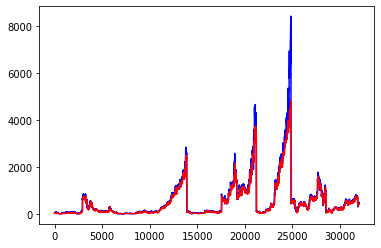

In [17]:
ran=range(32000)
#preds=preds.tolist('float64')
#preds.append(0)
plt.plot(ran, whole_targets, 'b', label='True')
plt.plot(ran, preds, 'r', label='Preds')
#plt.title('Truth and Preds')
#plt.xlabel('steps')
#plt.ylabel('close')
#plt.legend()
plt.show()